# A Text Mining Approach to Analyze The Cyber Security Related Articles

## PART-3: Text Mining

__Feature Engineering with NLP techniques__


__Importing of Required Libraries__

In [1]:
import nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from autocorrect import Speller
import pickle
import re


import spacy
import en_core_web_sm
from spacy import displacy

import numpy as np
import pandas as pd


import warnings
warnings.filterwarnings("ignore")

__Loading Data__

As mentioned Part-2 that pandas parquet options doesn't support timedelta type. So we need to use __fastparquet__ option, to keep the timedelta type format.

In [2]:
df_sum=pd.read_parquet('df_sum_parquet.gzip',engine='fastparquet')
df_investigator_cyber=pd.read_parquet('df_investigator_cyber_parque.gzip',engine='fastparquet')
df_sum.head(2)

,AwardID,AwardTitle,AwardEffectiveDate,AwardExpirationDate,AwardAmount,ProgramOfficer,Institution_Name,Institution_StateName,Abstract,Year,Award_Duration,AwardAmount_Million,Abstract_Lenght
0,0110599,Collaborative Research Testing Affect Control ...,2001-08-15,2004-07-31,300000.0,Patricia White,University of Arizona,Arizona,The investigators will conduct a series of exp...,2001,1081 days,0.30,2194
1,0112426,Federal Cyber Service Initiative,2001-06-01,2007-06-30,149995.0,Timothy V. Fossum,University of Tulsa,Oklahoma,This program produces a cadre of computer scie...,2001,2220 days,0.15,765


### A-) Word Frequency

__Replacing Of Contraction Words__

In [3]:
#Replace contraction words to alternative forms before tokenization
replacement_patterns = {
    r"won\'t": "will not",
    r"can\'t": "cannot",
    r"i\'m": "i am",
    r"ain\'t": "is not",
    r"(\w+)\'ll": "\g<1> will",
    r"(\w+)n\'t": "\g<1> not",
    r"(\w+)\'ve": "\g<1> have",
    r"(\w+)\'s": "\g<1> is",
    r"(\w+)\'re": "\g<1> are",
    r"(\w+)\'d": "\g<1> would",
    r"&": "and",
    r"<br/>":" "}

df_sum['Abstract']=df_sum['Abstract'].replace(replacement_patterns, regex=True)
df_sum.head(2)

,AwardID,AwardTitle,AwardEffectiveDate,AwardExpirationDate,AwardAmount,ProgramOfficer,Institution_Name,Institution_StateName,Abstract,Year,Award_Duration,AwardAmount_Million,Abstract_Lenght
0,0110599,Collaborative Research Testing Affect Control ...,2001-08-15,2004-07-31,300000.0,Patricia White,University of Arizona,Arizona,The investigators will conduct a series of exp...,2001,1081 days,0.30,2194
1,0112426,Federal Cyber Service Initiative,2001-06-01,2007-06-30,149995.0,Timothy V. Fossum,University of Tulsa,Oklahoma,This program produces a cadre of computer scie...,2001,2220 days,0.15,765


__Merge All Values in Abstract Columns to A Single String__

In [4]:
abstract_list=df_sum['Abstract'].tolist()
abstract_sum=' '.join(abstract_list)
print('Total character number of all Abstract columns is: {}'.format(len(abstract_sum)))

Total character number of all Abstract columns is: 17247941


__Tokenization and LowerCase__

In [5]:
#word tokenization
wrd_list = nltk.word_tokenize(abstract_sum)

#lowercase
wrd_list=[w.lower() for w in wrd_list]
print('Total lowercase words: {}'.format(len(wrd_list)))

Total lowercase words: 2699956


__Remove Numbers__

In [6]:
#remove numbers
wrd_list_alpha=[w for w in wrd_list if w.isalpha()]
print('Total words consist of only alphabets: {}'.format(len(wrd_list_alpha)))

Total words consist of only alphabets: 2345704


__Remove Written Form of Numbers__

In [7]:
#Create numbers in written form for ignoring
num_written= {1: 'one', 2: 'two', 3: 'three', 4: 'four', 5: 'five', \
             6: 'six', 7: 'seven', 8: 'eight', 9: 'nine', 10: 'ten', \
            11: 'eleven', 12: 'twelve', 13: 'thirteen', 14: 'fourteen', \
            15: 'fifteen', 16: 'sixteen', 17: 'seventeen', 18: 'eighteen', \
            19: 'nineteen', 20: 'twenty', 30: 'thirty', 40: 'forty', \
            50: 'fifty', 60: 'sixty', 70: 'seventy', 80: 'eighty', \
            90: 'ninety', 0: 'zero'}

num_list=list(np.arange(0,100))

num2words_list=[]

def num2words(n):
    try:
        return num_written[n]
    except:
        try:
            return num2words(n-n%10) + num2words(n%10)
        except:
            return 'None'

        
for num in num_list:
    num2words_list.append(num2words(num))
    
wrd_list_rm_written_form = [w for w in wrd_list_alpha if w not in num2words_list]
print('Total words consist of only alphabets: {}'.format(len(wrd_list_rm_written_form)))

Total words consist of only alphabets: 2339123


__Remove Stopwords__

In [8]:
#define stopwords list
stopwords_list=nltk.corpus.stopwords.words('english')

#extend the stopwords list
stopwords_list.extend(['cannot','many','much','also','well','better','via'])

wrd_list_rm_stopwords = [w for w in wrd_list_rm_written_form if w not in stopwords_list]
print('Total words after removing stopwords: {}'.format(len(wrd_list_rm_stopwords)))

Total words after removing stopwords: 1430837


__Remove 1-Length Words__

In [9]:
#remove 1-len words
wrd_list_one_len = [w for w in wrd_list_rm_stopwords if len(w)>=2]

print('Total words after removing 1-len words: {}'.format(len(wrd_list_one_len)))

Total words after removing 1-len words: 1429707


__Counting The Words Frequency__

In [10]:
freq_dict_before=nltk.FreqDist(wrd_list_one_len)
print('Total unique words before lemmatization: {}'.format(len(freq_dict_before)))

Total unique words before lemmatization: 32869


In [11]:
print('First 50 frequency words:\n{}'.format(freq_dict_before.most_common(50)))

First 50 frequency words:
[('research', 19775), ('project', 16842), ('data', 12652), ('systems', 9240), ('students', 9053), ('new', 8683), ('science', 7465), ('security', 5938), ('system', 5444), ('development', 5256), ('information', 5057), ('support', 4805), ('program', 4688), ('design', 4687), ('engineering', 4513), ('university', 4483), ('using', 4420), ('network', 4417), ('education', 4416), ('community', 4376), ('develop', 4324), ('use', 4251), ('learning', 4248), ('software', 4207), ('provide', 4036), ('materials', 3872), ('tools', 3748), ('cyberinfrastructure', 3592), ('technology', 3590), ('computing', 3432), ('researchers', 3413), ('applications', 3397), ('broader', 3298), ('work', 3224), ('nsf', 3182), ('cybersecurity', 3170), ('scientific', 3157), ('infrastructure', 3137), ('control', 3135), ('computer', 3132), ('computational', 3108), ('methods', 3043), ('analysis', 3024), ('high', 3000), ('award', 2992), ('including', 2975), ('used', 2974), ('models', 2857), ('national', 

__Lemmatization__

In [12]:
#Lemmatization
lemmatizer = WordNetLemmatizer()

wrd_list_lemmas = [lemmatizer.lemmatize(w) for w in wrd_list_one_len]

#Recounting the Words Frequency
freq_dict=nltk.FreqDist(wrd_list_lemmas)

print('Total unique words after lemmatization: {}'.format(len(freq_dict)))


Total unique words after lemmatization: 29227


In [13]:
print('First 50 frequency words:\n{}'.format(freq_dict.most_common(50)))

First 50 frequency words:
[('research', 19785), ('project', 18508), ('system', 14684), ('data', 12652), ('student', 10589), ('science', 8697), ('new', 8683), ('network', 7002), ('program', 6420), ('security', 5938), ('technology', 5916), ('community', 5824), ('support', 5752), ('impact', 5602), ('development', 5515), ('university', 5237), ('design', 5101), ('model', 5099), ('information', 5057), ('application', 4856), ('material', 4616), ('engineering', 4513), ('tool', 4501), ('using', 4420), ('education', 4419), ('develop', 4324), ('use', 4251), ('learning', 4248), ('software', 4209), ('provide', 4036), ('process', 3613), ('approach', 3592), ('cyberinfrastructure', 3592), ('researcher', 3572), ('infrastructure', 3570), ('method', 3544), ('computer', 3513), ('resource', 3513), ('computing', 3432), ('study', 3393), ('activity', 3387), ('analysis', 3360), ('work', 3344), ('control', 3312), ('broader', 3298), ('nsf', 3184), ('cybersecurity', 3170), ('scientific', 3157), ('computational', 

__Saving The Result__

In [14]:
df_FreqDist=pd.DataFrame({'Words':list(freq_dict.keys()),'Count':list(freq_dict.values())})
df_FreqDist.sort_values(by=['Count'],ascending=False,inplace=True)
df_FreqDist=df_FreqDist.reset_index(drop=True)
df_FreqDist.to_csv('FreqDist.csv')
df_FreqDist.head(3)

,Words,Count
0,research,19785
1,project,18508
2,system,14684


## B-) Clustering and Topic Modeling

In [15]:
#Create a new DataFrame
df_sum2=df_sum[['AwardID','Abstract']][:30]
df_sum2.head(2)

,AwardID,Abstract
0,0110599,The investigators will conduct a series of exp...
1,0112426,This program produces a cadre of computer scie...


__Replacing Of Contraction Words__

In [16]:
replacement_patterns = {
    r"won\'t": "will not",
    r"can\'t": "cannot",
    r"i\'m": "i am",
    r"ain\'t": "is not",
    r"(\w+)\'ll": "\g<1> will",
    r"(\w+)n\'t": "\g<1> not",
    r"(\w+)\'ve": "\g<1> have",
    r"(\w+)\'s": "\g<1> is",
    r"(\w+)\'re": "\g<1> are",
    r"(\w+)\'d": "\g<1> would",
    r"&": "and",
    r"<br/>":" "}

df_sum2['Abstract'].replace(replacement_patterns, regex=True, inplace=True)
df_sum2.head(2)

,AwardID,Abstract
0,0110599,The investigators will conduct a series of exp...
1,0112426,This program produces a cadre of computer scie...


__Removing Unneccesery Words__

We use __NER__ (Named Entity Recognition) function of __spacy__ library to detect named entities (people, places, organizations, dates, times etc.) from the text. After analyzing this words, we understood that they are unnecessary for clustering.

An example of visualization of NER:

In [17]:
#define the nlp object
nlp = en_core_web_sm.load()

doc=nlp(str(df_sum2['Abstract'][1]))

displacy.render(doc, style="ent",jupyter=True)

In [21]:
#create a list for NER
NER_list=[]

#Find
for n in range(df_sum2.shape[0]):
    doc=nlp(str(df_sum2['Abstract'][n]))

    for ent in doc.ents:
        NER_list.append(ent.text)

NER_list=list(set(NER_list)) #for unique elements in list
print('Total unique NER words: {}'.format(len(NER_list)))

print('Total words before removing NER: {}'.format(sum(df_sum2['Abstract'].str.len())))

for NER in NER_list:
    df_sum2['Abstract']=df_sum2['Abstract'].str.replace(NER,'')
print('Total words after removing NER: {}'.format(sum(df_sum2['Abstract'].str.len())))

Total unique NER words: 16
Total words after removing NER: 52927
Total words after removing NER: 52402


__Tokenization and LowerCase__

In [22]:
#word tokenization and lowercase
df_sum2['Abstract_Tokens'] = df_sum2['Abstract'].str.lower().apply(nltk.word_tokenize)
print('Total words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words: 8516


,AwardID,Abstract,Abstract_Tokens
0,0110599,The investigators will conduct a series of exp...,"[the, investigators, will, conduct, a, series,..."
1,0112426,This program produces a cadre of computer scie...,"[this, program, produces, a, cadre, of, comput..."


__Remove Numbers__

In [23]:
#remove numbers
for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in (abstract for abstract in df_sum2['Abstract_Tokens'][n]) if w.isalpha()]
print('Total words consist of only alphabets: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words consist of only alphabets: 7335


,AwardID,Abstract,Abstract_Tokens
0,0110599,The investigators will conduct a series of exp...,"[the, investigators, will, conduct, a, series,..."
1,0112426,This program produces a cadre of computer scie...,"[this, program, produces, a, cadre, of, comput..."


__Remove Stopwords__

In [24]:
#define stopwords list
stopwords_list=nltk.corpus.stopwords.words('english')

#extend the stopwords list
stopwords_list.extend(['cannot','many','much','also','well','better','via'])

#extend the stopwords list with unneccessary words
stopwords_list.extend(['abstract'])


for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in (abstract for abstract in df_sum2['Abstract_Tokens'][n]) if w not in stopwords_list]
print('Total words after removing stopwords: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing stopwords: 4217


,AwardID,Abstract,Abstract_Tokens
0,0110599,The investigators will conduct a series of exp...,"[investigators, conduct, series, experiments, ..."
1,0112426,This program produces a cadre of computer scie...,"[program, produces, cadre, computer, scientist..."


__Lemmatization__

In [25]:
#Lemmatization
lemmatizer = WordNetLemmatizer()

for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[lemmatizer.lemmatize(w) for w in (abstract for abstract in df_sum2['Abstract_Tokens'][n])]

print('Total words after lemmatization: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after lemmatization: 4217


,AwardID,Abstract,Abstract_Tokens
0,0110599,The investigators will conduct a series of exp...,"[investigator, conduct, series, experiment, fo..."
1,0112426,This program produces a cadre of computer scie...,"[program, produce, cadre, computer, scientist,..."


__Remove 1-Length Words__

Punctuation
Punctuation are the unnecessary symbols that are in our corpus documents,

In [26]:
#remove 1-len words
for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in (abstract for abstract in df_sum2['Abstract_Tokens'][n]) if len(w)>=2]
print('Total words after removing 1-len words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing 1-len words: 4203


,AwardID,Abstract,Abstract_Tokens
0,0110599,The investigators will conduct a series of exp...,"[investigator, conduct, series, experiment, fo..."
1,0112426,This program produces a cadre of computer scie...,"[program, produce, cadre, computer, scientist,..."


Abstract2 uniqi!!!
#Recounting the Words Frequency
freq_dict=nltk.FreqDist(wrd_list_lemmas)

print('Total unique words after lemmatization: {}'.format(len(freq_dict)))


__Convert Tokens To String Again__

In [27]:
df_sum2['Abstract2']=df_sum2['Abstract']
for n in range(df_sum2.shape[0]):
    df_sum2['Abstract2'][n]=' '.join([str(item) for item in df_sum2['Abstract_Tokens'][n]])
df_sum2.head(2)

,AwardID,Abstract,Abstract_Tokens,Abstract2
0,0110599,The investigators will conduct a series of exp...,"[investigator, conduct, series, experiment, fo...",investigator conduct series experiment focus c...
1,0112426,This program produces a cadre of computer scie...,"[program, produce, cadre, computer, scientist,...",program produce cadre computer scientist stron...


__TfidfVectorizer__

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
X = v.fit_transform(df_sum2['Abstract2'])
X.toarray()[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [29]:
v.get_feature_names()[:10]

['ability',
 'able',
 'academic',
 'accelerate',
 'acceptable',
 'access',
 'accessible',
 'accompanying',
 'accountability',
 'accuracy']

In [30]:
len(v.vocabulary_)

1427

__Create New DataFrame__

In [31]:
df = pd.DataFrame(data=X.toarray(), columns=v.get_feature_names())
df.head(2)

,ability,able,academic,accelerate,acceptable,access,accessible,accompanying,accountability,accuracy,...,workforce,working,workplace,workshop,world,worldwide,would,yamacrew,yet,youth
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=12)
#Run the clustering algorithm
model = k_means.fit(df)
model
#Generate cluster predictions and store in y_hat
y_hat = k_means.predict(X)
y_hat

array([ 4,  5,  5,  9,  7, 10, 11,  1,  2, 10,  1,  6,  0,  3,  2,  2,  5,
        7,  0,  7,  5,  8,  0,  8,  8,  8,  3,  3,  3,  3])

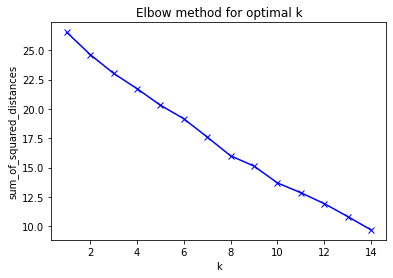

In [33]:
import matplotlib.pyplot as plt

#for each value of k, we can initialise k_means and use inertia to identify the sum of squared distances of samples to the nearest cluster centre
sum_of_squared_distances = []
K = range(1,15)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(df)
    sum_of_squared_distances.append(k_means.inertia_)
    
    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow method for optimal k')
plt.show()

In [34]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=3)
#Run the clustering algorithm
model = k_means.fit(df)
model
#Generate cluster predictions and store in y_hat
y_hat = k_means.predict(X)
y_hat

array([1, 2, 2, 1, 1, 0, 2, 2, 1, 0, 2, 1, 0, 1, 2, 1, 2, 1, 0, 1, 2, 2,
       0, 2, 2, 2, 0, 0, 0, 0])

In [35]:
labels=list(y_hat)
df_sum2['Label']=labels
df_sum2.to_csv('df_sum_clustering.csv')
df_sum2.head(2)

,AwardID,Abstract,Abstract_Tokens,Abstract2,Label
0,0110599,The investigators will conduct a series of exp...,"[investigator, conduct, series, experiment, fo...",investigator conduct series experiment focus c...,1
1,0112426,This program produces a cadre of computer scie...,"[program, produce, cadre, computer, scientist,...",program produce cadre computer scientist stron...,2


In [39]:
df_sum2[df_sum2['Label']==2]

,AwardID,Abstract,Abstract_Tokens,Abstract2,Label
1,0112426,This program produces a cadre of computer scie...,"[program, produce, cadre, computer, scientist,...",program produce cadre computer scientist stron...,2
2,0114016,This project relieves the shortage of qualifie...,"[project, relief, shortage, qualified, informa...",project relief shortage qualified information ...,2
6,0201303,MS- and This award provides partial support...,"[award, provides, partial, support, active, re...",award provides partial support active research...,2
7,0201873,In response to the national need for informati...,"[response, national, need, information, techno...",response national need information technology ...,2
10,0204267,"- Good, , , , : The Research Compnt of a ...","[good, research, compnt, model, college, itwf,...",good research compnt model college itwf award ...,2
14,0208848,The objective of the proposed research is to i...,"[objective, proposed, research, improve, nerk,...",objective proposed research improve nerk secur...,2
16,0210334,"(UC), (), and Technology at (), () and (...","[uc, technology, improving, institutional, reg...",uc technology improving institutional regional...,2
20,0220785,This scholarship project provides funds for c...,"[scholarship, project, provides, fund, compute...",scholarship project provides fund computer sci...,2
21,0221722,This project will examine the framework for su...,"[project, examine, framework, supporting, secu...",project examine framework supporting security ...,2
23,0224889,Information security has become a critical con...,"[information, security, become, critical, conc...",information security become critical concern g...,2


In [37]:
#make array from number of occurrences
occ = np.asarray(X.sum(axis=0)).ravel().tolist()

In [ ]:
bowListFrame = pd.DataFrame({'term': v.get_feature_names(), 'occurrences': occ})
bowListFrame

In [ ]:
import texthero as hero
df_sum2['tfidf'] = hero.tfidf(df_sum2['Abstract2'])
df_sum2.head(2)

__TEST__

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfs = tfidf.fit_transform(df_sum2['Abstract'].values)
tfs.toarray()

In [ ]:
from sklearn.neighbors import NearestNeighbors

model_tf_idf = NearestNeighbors(metric='cosine', algorithm='brute')
model_tf_idf.fit(tfs)

In [ ]:
model_tf_idf.transforms(tfs)